In [3]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint
from datetime import datetime

sys.path.append('../..')

In [30]:
# from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import general_arbitrage, invest_all
from model.amm.global_state import GlobalState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.exchange import Exchange
from model import run
import model.plot_utils as pu

class CEXDummy(Exchange):
    def __init__(self, tokens: dict[str: float], unique_id='dummy exchange'):
        super().__init__()
        self.prices = tokens
        self.liquidity = {tkn: 0 for tkn in tokens}
        self.asset_list = list(tokens.keys())
        self.unique_id = unique_id

    def price(self, tkn: str, denomination: str = ''):
        if denomination and denomination not in self.prices:
            raise ValueError(f'Denomination {denomination} not in exchange')
        return self.prices[tkn] / (self.prices[denomination] if denomination in self.prices else 1)

    def buy_spot(self, tkn_buy, tkn_sell, fee=0):
        return self.price(tkn_buy) / self.price(tkn_sell)

    def sell_spot(self, tkn_sell, tkn_buy, fee=0):
        return self.price(tkn_sell) / self.price(tkn_buy)

    def buy_limit(self, tkn_buy, tkn_sell):
        return float('inf')

    def sell_limit(self, tkn_buy, tkn_sell):
        return float('inf')
    
    def swap(
            self,
            agent: Agent,
            tkn_buy: str,
            tkn_sell: str,
            buy_quantity: float = 0,
            sell_quantity: float = 0
    ):
        if buy_quantity:
            sell_quantity = self.calculate_sell_from_buy(tkn_buy, tkn_sell, buy_quantity)
        elif sell_quantity:
            buy_quantity = self.calculate_buy_from_sell(tkn_buy, tkn_sell, sell_quantity)

        if tkn_buy not in agent.holdings:
            agent.holdings[tkn_buy] = 0

        agent.holdings[tkn_sell] -= sell_quantity
        agent.holdings[tkn_buy] += buy_quantity
        self.liquidity[tkn_sell] += sell_quantity
        self.liquidity[tkn_buy] -= buy_quantity

    def calculate_buy_from_sell(self, tkn_buy, tkn_sell, sell_quantity):
        return sell_quantity * self.price(tkn_sell) / self.price(tkn_buy)

    def calculate_sell_from_buy(self, tkn_sell, tkn_buy, buy_quantity):
        return buy_quantity * self.price(tkn_buy) / self.price(tkn_sell)

rebase_amount = 1000        
def rebase(tkn: str, amount: float):
    def evolve(state: GlobalState):
        tkn_holders = {
            pool: pool.liquidity[tkn]
            for pool in state.pools.values()
        }
        tkn_holders.update({
            agent: agent.holdings[tkn]
            for agent in state.agents.values()
        })
        total_supply = sum(tkn_holders.values())
        awards = 0
        for holder in tkn_holders:
            if isinstance(holder, Agent):
                awards += rebase_amount * holder.holdings[tkn] / total_supply
                holder.holdings[tkn] += rebase_amount * holder.holdings[tkn] / total_supply
            elif isinstance(holder, Exchange):
                awards += rebase_amount * holder.liquidity[tkn] / total_supply
                holder.liquidity[tkn] += rebase_amount * holder.liquidity[tkn] / total_supply
        # if (state.time_step % 100 == 0):
        #     print(total_supply)
        #     print(awards)
        return state
    return evolve

def geometric_progression(min_val, max_val, steps):
    return [min_val * (max_val/min_val) ** (i/(steps-1)) for i in range(steps)]

binance = CEXDummy({'S1': 1, 'S2': 1}, 'binance')

stableswap = StableSwapPoolState(
    tokens={'S1': 1000000, 'S2': 1000000},
    amplification=10,
    trade_fee=0,
    unique_id='stableswap'
)

# arbitrageur = Agent(
#     holdings={'S1': 1000000, 'S2': 1000000},
#     trade_strategy=general_arbitrage([stableswap, binance], config=[{'exchanges': {'stableswap': ('S1', 'S2'), 'binance': ('S1', 'S2')}, 'buffer': 0}])
# )

agent = Agent(
    holdings={'S1': 1000}
)

initial_state = GlobalState(
    pools={'stableswap': stableswap, 'binance': binance},
    agents={'arbitrageur': arbitrageur},
    external_market={'S1': 1, 'S2': 1},
    # evolve_function=rebase('S1')
)

params = {
    'amplification': (10, 10000),
    'asset_imbalance': (1, 1.0005),
    'rebase_amount': (1000, 1000000)
}

steps = 100
asset_balance = 1

for amp in geometric_progression(params.amplification[0], params.amplification[1], steps):
    for initial_price in geometric_progression(params['asset_imbalance'][0], params['asset_imbalance'][1], steps):
        stableswap.amplification = 1000
        current_price = stableswap.price_at_balance([stableswap.liquidity['S2'] * asset_balance, stableswap.liquidity['S2']])
        iters = 0
        # print(f'price target: {initial_price}')
        # adjust the liquidity balance to reach the desired starting price
        while abs(current_price - initial_price) > 1e-20 and iters < 1000:
            iters += 1
            if current_price > initial_price:
                asset_balance -= 1 / 2 ** iters
            elif current_price < initial_price:
                asset_balance += 1 / 2 ** iters
            current_price = stableswap.price_at_balance([stableswap.liquidity['S2'] * asset_balance, stableswap.liquidity['S2']])
        # print(f'final price: {current_price} at {asset_balance} to 1')
        # find the minimum rebase amount which makes an attack profitable
        

price target: 1.0
final price: 1.0 at 1 to 1
price target: 1.0000050492555923
final price: 1.0000050492555923 at 1.00506703261226 to 1
price target: 1.0000100985366798
final price: 1.0000100985366798 at 1.0101594147029118 to 1
price target: 1.0000151478432624
final price: 1.0000151478432624 at 1.015276944611287 to 1
price target: 1.00002019717534
final price: 1.00002019717534 at 1.020419415026936 to 1
price target: 1.0000252465329131
final price: 1.0000252465329131 at 1.025586613100586 to 1
price target: 1.0000302959159817
final price: 1.0000302959159817 at 1.0307783205607848 to 1
price target: 1.000035345324546
final price: 1.000035345324546 at 1.0359943138362269 to 1
price target: 1.000040394758606
final price: 1.000040394758606 at 1.041234364182401 to 1
price target: 1.0000454442181619
final price: 1.0000454442181619 at 1.0464982378134664 to 1
price target: 1.0000504937032137
final price: 1.0000504937032137 at 1.0517856960366316 to 1
price target: 1.0000555432137617
final price: 1.0

In [47]:
events = run.run(initial_state, time_steps=2000)

Starting simulation...
Execution time: 4.454 seconds.


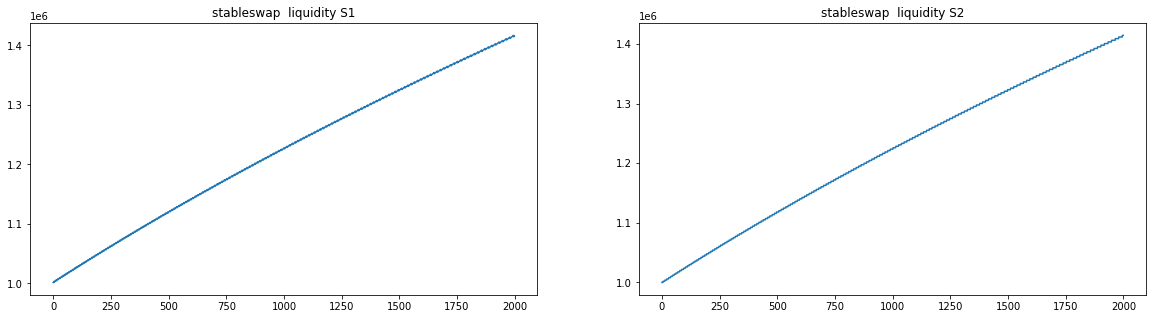

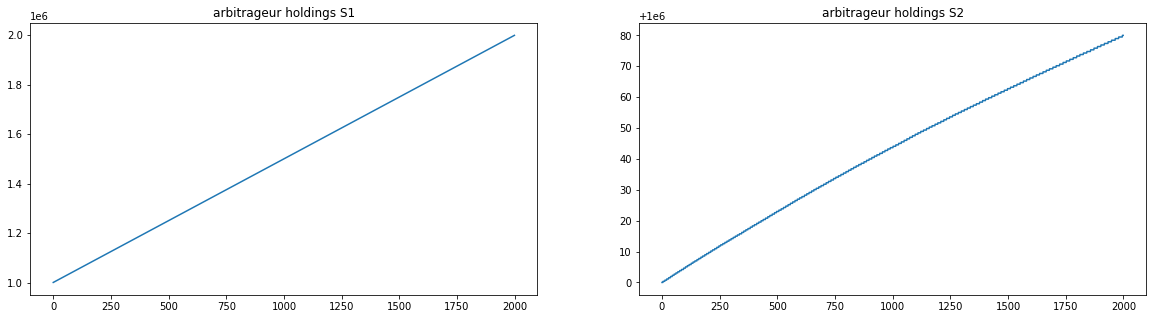

In [48]:
pu.plot(events, pool='stableswap', prop='liquidity')
pu.plot(events, agent='arbitrageur', prop='holdings', key=['S1', 'S2'])

In [49]:
impermanent_loss = [
    (1 - event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market)
    / sum(event.agents['non_LP'].holdings.values())) * 100
    for event in events
]
total_supply = [
    sum([
        event.pools['stableswap'].liquidity['S1'], 
        event.agents['arbitrageur'].holdings['S1'], 
        event.agents['LP'].holdings['S1'], 
        event.agents['non_LP'].holdings['S1']
    ]) for event in events
]
impermanent_loss_2 = [
    (1 - event.pools['stableswap'].calculate_remove_liquidity(
        event.agents['LP'], event.agents['LP'].holdings['stableswap'], 'S1'
    ) / sum(event.agents['non_LP'].holdings.values())) * 100
    for event in events
]

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

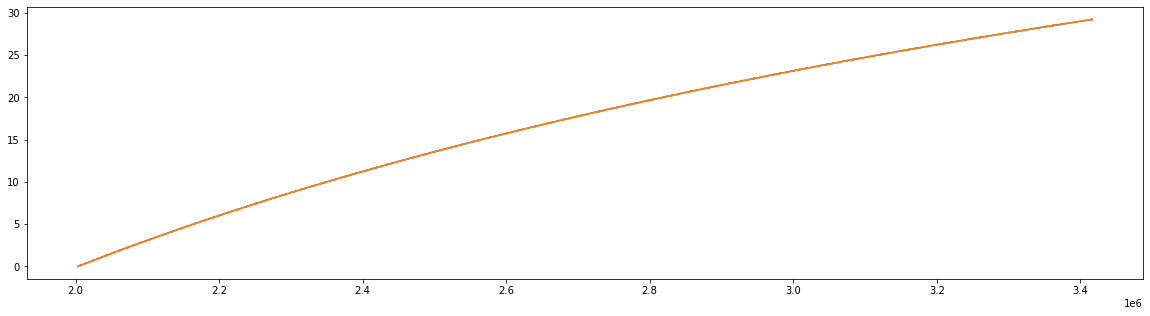

In [50]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, impermanent_loss)
plt.plot(total_supply, impermanent_loss_2)
plt.title

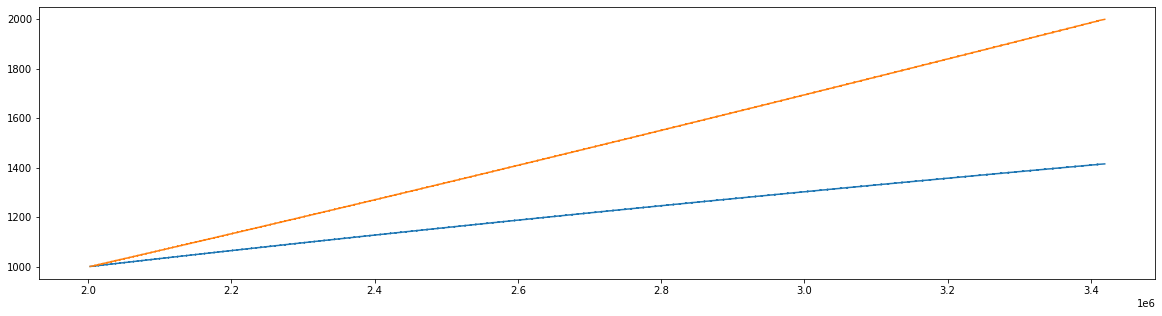

In [44]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, [event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market) for event in events])
plt.plot(total_supply, [sum(event.agents['non_LP'].holdings.values()) for event in events])

In [45]:
events[-1].agents['non_LP'].holdings['S1']

1999.0009990010549

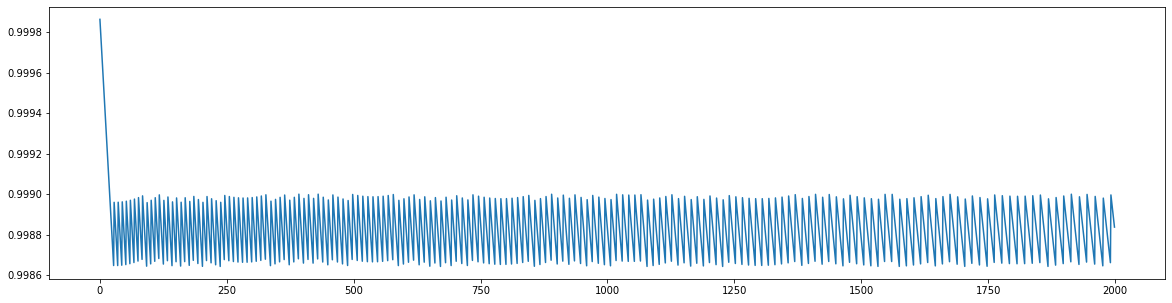

In [25]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['stableswap'].price('S1', 'S2') for event in events])

In [26]:
event = events[-1]
print(event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market))

1416.592232209322


In [27]:
stablepool = event.pools['stableswap']
agent = event.agents['LP']

share_fraction = agent.holdings[stablepool.unique_id] / stablepool.shares
delta_tkns = {tkn: share_fraction * stablepool.liquidity[tkn] for tkn in stablepool.asset_list}  # delta_tkn is positive
print(delta_tkns)
# print([delta_tkns[tkn] * prices[tkn] for tkn in stablepool.asset_list])

{'S1': 712.8285046562819, 'S2': 703.7637275530402}


In [30]:
impermanent_loss[-1] - impermanent_loss_2[-1]

29.134991282284272

In [13]:
stablepool.shares

2000999.7042730716

In [33]:
(
    events[-1].pools['stableswap'].cash_out(events[-1].agents['LP'], events[-1].external_market),
    event.pools['stableswap'].calculate_remove_liquidity(
        event.agents['LP'], event.agents['LP'].holdings['stableswap'], 'S1'
    )
)

(1416.592232209322, 1416.6751923540141)